# cats and dogs image recognition

In [35]:
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img, load_img
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

In [36]:
# 1. download from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# 2. move to directory /tmp/datasets/
train_dir = "/tmp/datasets/cats_and_dogs/train/"
validation_dir = "/tmp/datasets/cats_and_dogs/validation/"

In [37]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#1. download from https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
#2. move to directory /tmp/datasets/pretrained/

local_weights_file = '/tmp/datasets/pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [38]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [39]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [40]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001),metrics=['acc'])

In [41]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2003 images belonging to 3 classes.
Found 1003 images belonging to 3 classes.


In [48]:
# type of classes 
classes=list(train_generator.class_indices.items())
classes

[('cats', 0), ('dogs', 1), ('flowers', 2)]

In [42]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
100/100 - 59s - loss: 0.3723 - acc: 0.8573 - val_loss: 0.0948 - val_acc: 0.9600
Epoch 2/2
100/100 - 62s - loss: 0.1991 - acc: 0.9193 - val_loss: 0.0776 - val_acc: 0.9570


In [ ]:
## save model
model.save("cats_dogs_v2")

Text(0.5, 1.0, 'Training and validation loss')

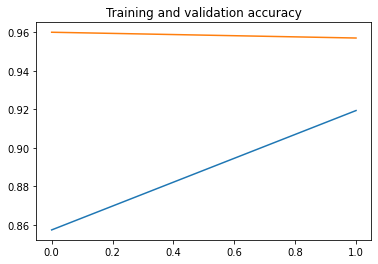

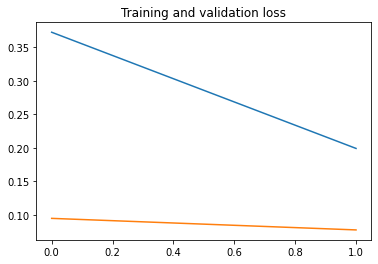

In [43]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [44]:
# evaluate model
accx = model.evaluate_generator(generator=validation_generator, steps=20, verbose=0)
print(accx)
print('> %.3f' % (accx[0] * 100.0),'> %.3f' % (accx[1] * 100.0))

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.11906057596206665, 0.9449999928474426]
> 11.906 > 94.500


In [45]:
print("total testing samples:", validation_generator.samples)
pp=model.predict_generator(generator=validation_generator, steps=20, verbose=0)
print("total predictions from testing samples:", len(pp))
cats=0
dogs=0
flowers=0
for p in pp:
    #print(p, classes[int(p[0])])
    if(int(p[0])==0):
        cats=cats+1
    elif(int(p[0])==1):
        dogs=dogs+1
    else:
         flowers=flowers+1;
print("matched samples cats:{},dogs:{},flowers:{}".format(cats,dogs,flowers))   

total testing samples: 1003
Instructions for updating:
Please use Model.predict, which supports generators.
total predictions from testing samples: 400
matched samples cats:327,dogs:73,flowers:0


In [56]:
matched=0
for i in range(2000, 2499, 1):
    img = load_img("datasets/cats_and_dogs/validation/dogs/dog."+str(i)+".jpg", target_size=(150, 150))  # this is a PIL image
    x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
    # Rescale by 1/255
    x /= 255
    pred=model.predict(x)
   
    if(int(pred[0])==1):
        #print(i,classes[int(pred[0])])
        matched=matched+1
        #plt.imshow(array_to_img(x[0]))
        #plt.show()
print("total:", matched)

total: 182


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)